# Async Task Processing in Ray Serve

## Problem Statement

Ray Serve customers need a way to handle long-running API requests asynchronously. For example, when a user requests video or document indexing, the system should enqueue the task in a background queue for later processing. The API should return a quick response while the task executes asynchronously.

## Traditional Solution and Its Challenges

A common approach is to use a message broker to queue tasks and a stream processor to handle them asynchronously. However, this introduces complexity for customers who lack the infrastructure for online stream processing, requiring them to manage and scale additional components.

<img src="./stream_processor.png" width="800" />

## Proposed Solution

For Anyscale customers using Ray Serve, we propose hosting **Celery Workers as Ray Serve Deployments**. Since Celery supports various message brokers (e.g., SQS, Redis, RabbitMQ), users can bring their own message brokers for async task queuing.

This approach slightly deviates from Ray Serve’s original request-response model by enabling it to support long-running stream processing applications.

<img src="./serve_stream_processor.png" width="800" />


## Alternatives Considered

1. **Using Ray Tasks within a Deployment Handler**  

```python
indexing_worker.remote(video_id, "https://www.youtube.com/watch?v=dQw4w9WgXcQ")
```

While Ray is designed for distributed task execution, this approach fails because the indexing_worker task would share fate with the MyApp deployment. During service rollouts, Ray's garbage collection may cancel in-progress tasks.

2. **Building a Custom Stream Processor**

Developing a custom solution to support multiple message brokers would require significant effort. Celery already provides this functionality, making it the better choice.

## Current Status
Support for Celery within Ray Serve is experimental, and recommendations may evolve. This document serves as an initial exploration of the approach.

In [1]:
import asyncio
import json
import threading
import time
import uuid
from celery import Celery
from fastapi import FastAPI, Request
from ray import serve
import ray
import redis
import requests
import numpy as np
import matplotlib.pyplot as plt

# dont show warnings
import warnings
warnings.filterwarnings("ignore")

## What's Covered in This Notebook

1. **Start Redis Server**  
   - Set up a Redis instance to act as the message broker for Celery.

2. **Define Two Ray Serve Applications**  
   - **`TaskProcessor`**: Runs Celery workers and contains user-defined tasks.  
   - **`MyApp`**: The main Ray Serve application that handles API requests.

3. **Deploy and Demonstrate Async Task Processing**  
   - Deploy both applications within a single Ray Serve deployment.  
   - Show how routes in `MyApp` can enqueue tasks in Celery for asynchronous execution.


## Start Redis

In [2]:
!docker run -d --name redis-stack-server -p 6379:6379 redis/redis-stack-server:latest

docker: Error response from daemon: Conflict. The container name "/redis-stack-server" is already in use by container "3d9d3050d37b81325077cf4417083e2bf7b5c100ad60334fb54094e6e4faeabc". You have to remove (or rename) that container to be able to reuse that name.
See 'docker run --help'.


In [3]:
redis_client = redis.Redis(host='localhost', port=6379, db=0)

## Define the serve application

In [4]:
ray.init(ignore_reinit_error=True)

fastapi_app = FastAPI()

# Create Celery application
celery_app = Celery('task_queue', 
                    broker_url='redis://localhost',
                    backend='redis://localhost')

@serve.deployment(
    name="task_processor",
    num_replicas=10,
)
class TaskProcessor:
    """
    A single deployment that is responsible for all task processing
    across all serve applications.

    Its recommended that this deployment is not passed to other deployments
    as a handler because
    1. the way we would enqueue task is by calling celery_app.send_task("document_indexing_task", args=(document_id,))
    so there is no reason to use the handler to call into this deployment.
    2. 
    """
    def __init__(self):
        self.worker = celery_app.Worker(
            # prefork is not supported in serve deployment actor because we want the worker (and tasks)
            # to be in the same process as the replica actor.
            # this means that cpu intensive tasks will block the main thread
            pool_cls='threads',
            loglevel='INFO',
            concurrency=10
        )
        def run_worker():
            """
            starting worker here so that its part of the same process as the replica actor

            we want to use threads here because the tasks that worker
            spawns should be the same process as the worker and replica actor.
            the other option is to use solo, but that does not provide any
            concurrency.
            """
            
            self.worker.start()
        
        # TODO: automatically register all tasks in the celery app, this enumeration is error prone
        celery_app.task(self.document_indexing_task, name="document_indexing_task", acks_late=True)
        
        worker_thread = threading.Thread(target=run_worker)
        worker_thread.start()
        
        # create a large numpy array
        self.arr = np.random.rand(1000000)
    
    def __del__(self):
        # allow the worker to finish all the tasks in the queue
        self.worker.stop()
    
    def document_indexing_task(self, document_id: str):
        """
        blocking IO operations are allowed here since they are running in a thread from ThreadPoolExecutor
        """

        # task has access to replica actor object because tasks are running in the same process
        # so there is no serialization overhead
        print(np.sum(self.arr))

        # example of making a http request
        # requests.get(f"http://localhost:8000/my_app/index_document_sync?document_id={document_id}").json()

        # example of calling another deployment
        serve.get_app_handle("my_app").index_document_sync.remote(document_id).result()
        return


@serve.deployment(
    name="my_app",
    # since celery tasks are calling into `index_document_sync`, set this parameter appropriately.
    max_ongoing_requests=100
)
@serve.ingress(fastapi_app)
class MyApp:
    def __init__(self):
        self.redis_client = redis.Redis(host='localhost', port=6379, db=0)

    @fastapi_app.get("/index_document_async")
    def index_document_async(self, request: Request):
        # write to redis
        document_id = request.query_params.get("document_id")
        # set the status to pending and timestamp
        self.redis_client.set(document_id, json.dumps({"status": "pending", "start_time": time.time()}))
        celery_app.send_task("document_indexing_task", args=(document_id,))
        return
    
    @fastapi_app.get("/index_document_sync")
    async def index_document_sync(self, request: Request):
        document_id = request
        await asyncio.sleep(5)
        # update the status to done and timestamp and calculate the time taken
        data = json.loads(self.redis_client.get(document_id))
        start_time = data["start_time"]
        end_time = time.time()
        time_taken = end_time - start_time
        self.redis_client.set(document_id, json.dumps({"status": "done", "start_time": start_time, "time_taken": time_taken, "end_time": end_time}))
        return
    

app = MyApp.bind()
task_processor = TaskProcessor.bind()

"""
its recommended to run task processor in a separate serve application
the reason is that if the task processor is part of the same serve application, then its difficult to
get the deployment topology right and that can get unmanageable.
"""
serve.run(app, name="my_app", route_prefix="/my_app")
serve.run(task_processor, name="task_processor", route_prefix="/task_processor")

2025-03-20 14:55:36,250	INFO worker.py:1832 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
(ProxyActor pid=93538) INFO 2025-03-20 14:55:37,963 proxy 127.0.0.1 -- Proxy starting on node eaa00c000d95dd407f542a92d3385066e36885ab64021d60df60be22 (HTTP port: 8000).
INFO 2025-03-20 14:55:38,012 serve 93519 -- Started Serve in namespace "serve".
(ProxyActor pid=93538) INFO 2025-03-20 14:55:37,994 proxy 127.0.0.1 -- Got updated endpoints: {}.
(ServeController pid=93542) INFO 2025-03-20 14:55:38,098 controller 93542 -- Deploying new version of Deployment(name='my_app', app='my_app') (initial target replicas: 1).
(ProxyActor pid=93538) INFO 2025-03-20 14:55:38,100 proxy 127.0.0.1 -- Got updated endpoints: {Deployment(name='my_app', app='my_app'): EndpointInfo(route='/my_app', app_is_cross_language=False)}.
(ProxyActor pid=93538) INFO 2025-03-20 14:55:38,104 proxy 127.0.0.1 -- Started <ray.serve._private.router.SharedRouterLongPollClient object at 0x11a925050>.
(Ser

(ServeReplica:task_processor:task_processor pid=93548)  
(ServeReplica:task_processor:task_processor pid=93548)  -------------- celery@abrar-FK79L5J97K.local v5.4.0 (opalescent)
(ServeReplica:task_processor:task_processor pid=93548) --- ***** ----- 
(ServeReplica:task_processor:task_processor pid=93548) -- ******* ---- macOS-15.3.1-arm64-arm-64bit 2025-03-20 14:55:40
(ServeReplica:task_processor:task_processor pid=93548) - *** --- * --- 
(ServeReplica:task_processor:task_processor pid=93548) - ** ---------- [config]
(ServeReplica:task_processor:task_processor pid=93548) - ** ---------- .> app:         task_queue:0x13d074b10
(ServeReplica:task_processor:task_processor pid=93548) - ** ---------- .> transport:   redis://localhost:6379//
(ServeReplica:task_processor:task_processor pid=93548) - ** ---------- .> results:     redis://localhost/
(ServeReplica:task_processor:task_processor pid=93548) - *** --- * --- .> concurrency: 10 (thread)
(ServeReplica:task_processor:task_processor pid=935

(ServeReplica:task_processor:task_processor pid=93558) 
(ServeReplica:task_processor:task_processor pid=93558) 
INFO 2025-03-20 14:55:41,247 serve 93519 -- Application 'task_processor' is ready at http://127.0.0.1:8000/task_processor.
INFO 2025-03-20 14:55:41,247 serve 93519 -- Deployed app 'task_processor' successfully.
INFO 2025-03-20 14:55:41,251 serve 93519 -- Started <ray.serve._private.router.SharedRouterLongPollClient object at 0x136675850>.


DeploymentHandle(deployment='task_processor')

## Make async Requests

In [5]:
# create list of 30 document ids
document_ids = [str(uuid.uuid4()) for _ in range(30)]
# make 30 parallel requests to the task processor
import requests
import threading

def make_request(document_id):
    requests.get(f"http://localhost:8000/my_app/index_document_async?document_id={document_id}")    

threads = []
for document_id in document_ids:
    thread = threading.Thread(target=make_request, args=(document_id,))
    thread.start()
    threads.append(thread)

for thread in threads:
    thread.join()

(ServeReplica:my_app:my_app pid=93544) INFO 2025-03-20 14:55:41,402 my_app_my_app 1c8pp93a 0c41c216-126c-461b-a0fd-e0f0a2aee174 -- GET /my_app/index_document_async 200 127.9ms
(ServeReplica:my_app:my_app pid=93544) INFO 2025-03-20 14:55:41,404 my_app_my_app 1c8pp93a be4a25cb-57eb-4fb1-b347-ae3b193a5759 -- GET /my_app/index_document_async 200 131.2ms
(ServeReplica:my_app:my_app pid=93544) INFO 2025-03-20 14:55:41,408 my_app_my_app 1c8pp93a a332cc54-f060-4558-a559-397abd26d87f -- GET /my_app/index_document_async 200 137.1ms
(ServeReplica:my_app:my_app pid=93544) INFO 2025-03-20 14:55:41,410 my_app_my_app 1c8pp93a b9a1477f-3e64-4c06-839b-bceb08967dee -- GET /my_app/index_document_async 200 131.0ms
(ServeReplica:my_app:my_app pid=93544) INFO 2025-03-20 14:55:41,411 my_app_my_app 1c8pp93a f5921df3-0ea4-435f-9106-6b7992afec97 -- GET /my_app/index_document_async 200 131.6ms
(ServeReplica:my_app:my_app pid=93544) INFO 2025-03-20 14:55:41,412 my_app_my_app 1c8pp93a e8dbd351-d543-4fdc-9701-22006

## Poll for results

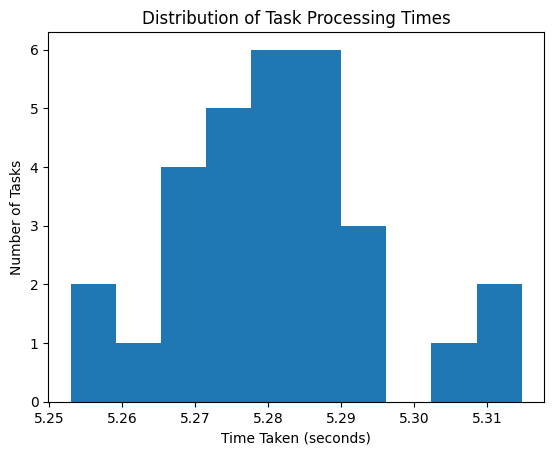

In [6]:
def are_tasks_done(document_ids):
    return all([json.loads(redis_client.get(document_id))["status"] == "done" for document_id in document_ids]) 

# wait until all tasks are done
while not are_tasks_done(document_ids):
    time.sleep(1)

# plot the time taken for each task add
time_taken = [json.loads(redis_client.get(document_id))["time_taken"] for document_id in document_ids]
plt.hist(time_taken, bins=10)
plt.xlabel('Time Taken (seconds)')
plt.ylabel('Number of Tasks')
plt.title('Distribution of Task Processing Times')
plt.show()


As you can see from the histogram, all tasks finish around 5 seconds.

## Caveats, Considerations, and Recommendations

1. **Task Delivery Guarantees Depend on the Message Broker**  
   - Different message brokers offer varying guarantees. For example, **SQS provides strong delivery guarantees**, whereas **Redis does not**.  
   - Refer to the [Celery documentation](https://docs.celeryq.dev/en/stable/getting-started/backends-and-brokers/) for broker and backend choices.

2. **At-Least-Once Processing Is Configuration Dependent**  
   - At-least-once processing in Celery depends on configuration parameters like:  
     - `task_acks_late`  
     - `task_acks_on_failure_or_timeout`  
     - `task_publish_retry`  
     - `task_publish_retry_policy`  
   - By default, Celery **does not guarantee at-least-once processing**. See [Celery FAQ](https://docs.celeryq.dev/en/stable/faq.html#faq-acks-late-vs-retry) for details.

3. **TaskProcessor Deployment Should Only Contain Celery Tasks** *(Recommendation, Not a Strict Requirement)*  
   - This simplifies future autoscaling, as task processor scaling can be based purely on queue characteristics.  
   - Mixing API routes in `TaskProcessor` could complicate autoscaling.

4. **Avoid Including TaskProcessor in Deployment Chains**  
   - There is **no need** to include `TaskProcessor` in any deployment chain since Celery tasks are invoked using:  
     ```python
     celery_app.send_task("document_indexing_task", args=(document_id,))
     ```  
   - This remains true until we find a way to support:  
     ```python
     document_indexing_task.delay(document_id)
     ```

5. **Celery Workers Run Inside Ray Actors** *(Key Design Choice)*  
   - Running Celery workers **inside Ray actors** ensures Ray manages their lifecycle, preventing zombie processes if an actor dies.  
   - However, this limits the Celery execution pool to **threads**. See [Celery Worker Pools](https://celery.school/celery-worker-pools) for available options.

6. **Concurrency Considerations**  
   - **For I/O-intensive tasks:** Increase Celery worker concurrency.  
   - **For CPU-intensive tasks:** Increasing thread concurrency **won’t help** due to the **GIL**. Instead, increase `num_replicas` on `TaskProcessor`.

7. **Celery Tasks That Call Other Deployments May Be Bottlenecked**  
   - If a Celery task invokes another Ray Serve deployment, **its concurrency is limited** by the `max_ongoing_requests` of the target deployment.

---

## Future Work

Currently, this solution is **DIY**, but future improvements should aim for deeper integration:

1. **Move `TaskProcessor` Into Ray Serve**  
   - Reduce boilerplate by abstracting Celery setup from users.

2. **Enable Autoscaling for Celery Workers**  
   - Implement autoscaling based on queue depth and processing load.

3. **Automate Celery Task Registration**  
   - Remove the need for users to manually register Celery tasks.
